In [1]:
import numpy as np
import netCDF4 as nc
import datetime
import xarray as xr
import matplotlib.path as mpath
import matplotlib.pyplot as plt
import pandas as pd
import cartopy.crs as ccrs
import cartopy.feature as feature
import matplotlib

%matplotlib inline

In [2]:
d = xr.open_dataset('/data/brogalla/ANHA12/ANHA12-EXH006_5d_gridT_y2002m01d05.nc')

In [3]:
sal = d['vosaline'][0,:,:,:].values
lon = d['nav_lon'].values
lat = d['nav_lat'].values

Text(0, 0.5, 'Surface Salinity')

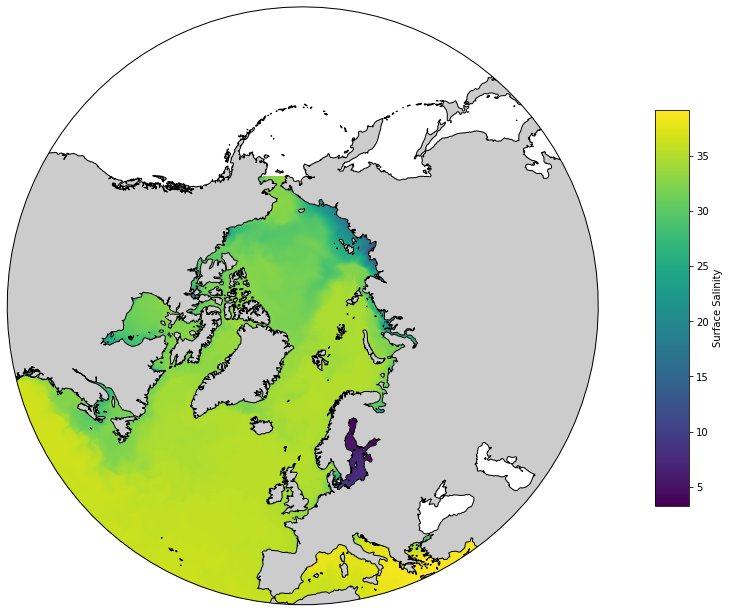

In [45]:
fig = plt.figure(figsize=(12, 11))
ax = plt.subplot(1, 1, 1, projection=ccrs.NorthPolarStereo())

ax.set_extent([-280, 80, 80, 35], crs=ccrs.PlateCarree())
land_50m = feature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='black', facecolor='gray', linewidth=0.5)
ax.add_feature(land_50m, color=[0.8, 0.8, 0.8])
ax.coastlines(resolution='50m')

theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)

# sal_var = np.ma.masked_array(np.isnan(sal[0,:,:]), sal[0,:,:])
# p1 = ax.contourf(lon, lat, sal_var, add_colorbar=False, transform=ccrs.PlateCarree(), \
#                  levels=range(0,36,2), extend ='both')
p1 = ax.pcolormesh(lon, lat, sal[0,:,:], transform=ccrs.PlateCarree())
ax_cb = plt.axes([0.92, 0.25, 0.04, 0.5])
cb = plt.colorbar(p1,cax=ax_cb, orientation='vertical')
cb.ax.set_ylabel('Surface Salinity')

Text(0, 0.5, 'Surface Salinity')

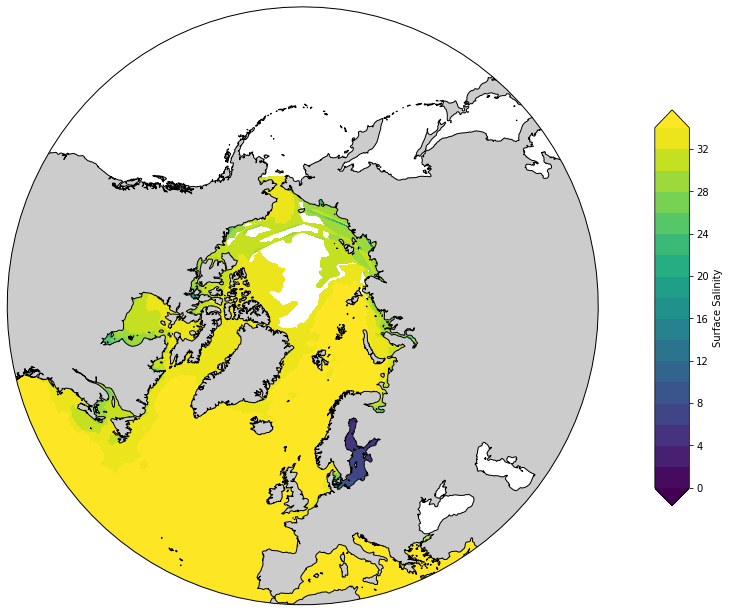

In [33]:
fig = plt.figure(figsize=(12, 11))
ax = plt.subplot(1, 1, 1, projection=ccrs.NorthPolarStereo())

ax.set_extent([-280, 80, 80, 35], crs=ccrs.PlateCarree())
land_50m = feature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='black', facecolor='gray', linewidth=0.5)
ax.add_feature(land_50m, color=[0.8, 0.8, 0.8])
ax.coastlines(resolution='50m')

theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)

p1 = ax.contourf(lon, lat, sal[0,:,:], add_colorbar=False, transform=ccrs.PlateCarree(), \
                 levels=range(0,36,2), extend ='both')
ax_cb = plt.axes([0.92, 0.25, 0.04, 0.5])
cb = plt.colorbar(p1,cax=ax_cb, orientation='vertical')
cb.ax.set_ylabel('Surface Salinity')

In [10]:
import cartopy.crs as ccrs

def z_masked_overlap(axe, X, Y, Z, source_projection=None):
    """
    for data in projection axe.projection
    find and mask the overlaps (more 1/2 the axe.projection range)

    X, Y either the coordinates in axe.projection or longitudes latitudes
    Z the data
    operation one of 'pcorlor', 'pcolormesh', 'countour', 'countourf'

    if source_projection is a geodetic CRS data is in geodetic coordinates
    and should first be projected in axe.projection

    X, Y are 2D same dimension as Z for contour and contourf
    same dimension as Z or with an extra row and column for pcolor
    and pcolormesh

    return ptx, pty, Z
    """
    if not hasattr(axe, 'projection'):
        return Z
    if not isinstance(axe.projection, ccrs.Projection):
        return Z

    if len(X.shape) != 2 or len(Y.shape) != 2:
        return Z

    if (source_projection is not None and
            isinstance(source_projection, ccrs.Geodetic)):
        transformed_pts = axe.projection.transform_points(
            source_projection, X, Y)
        ptx, pty = transformed_pts[..., 0], transformed_pts[..., 1]
    else:
        ptx, pty = X, Y


    with np.errstate(invalid='ignore'):
        # diagonals have one less row and one less columns
        diagonal0_lengths = np.hypot(
            ptx[1:, 1:] - ptx[:-1, :-1],
            pty[1:, 1:] - pty[:-1, :-1]
        )
        diagonal1_lengths = np.hypot(
            ptx[1:, :-1] - ptx[:-1, 1:],
            pty[1:, :-1] - pty[:-1, 1:]
        )
        to_mask = (
            (diagonal0_lengths > (
                abs(axe.projection.x_limits[1]
                    - axe.projection.x_limits[0])) / 2) |
            np.isnan(diagonal0_lengths) |
            (diagonal1_lengths > (
                abs(axe.projection.x_limits[1]
                    - axe.projection.x_limits[0])) / 2) |
            np.isnan(diagonal1_lengths)
        )

        # TODO check if we need to do something about surrounding vertices

        # add one extra colum and row for contour and contourf
        if (to_mask.shape[0] == Z.shape[0] - 1 and
                to_mask.shape[1] == Z.shape[1] - 1):
            to_mask_extended = np.zeros(Z.shape, dtype=bool)
            to_mask_extended[:-1, :-1] = to_mask
            to_mask_extended[-1, :] = to_mask_extended[-2, :]
            to_mask_extended[:, -1] = to_mask_extended[:, -2]
            to_mask = to_mask_extended
        if np.any(to_mask):

            Z_mask = getattr(Z, 'mask', None)
            to_mask = to_mask if Z_mask is None else to_mask | Z_mask

            Z = ma.masked_where(to_mask, Z)

        return ptx, pty, Z

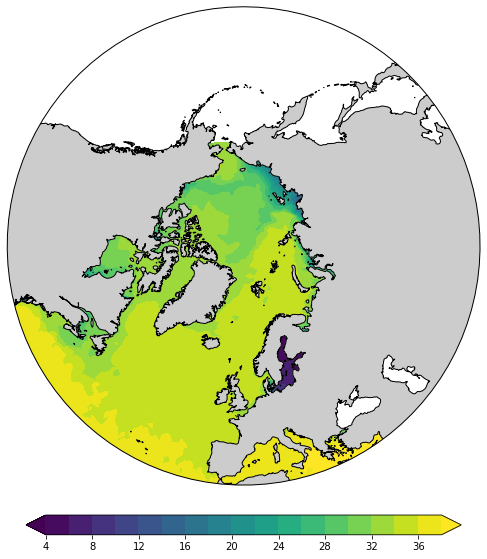

In [12]:
fig = plt.figure(figsize=(12, 11))
ax = plt.subplot(1, 1, 1, projection=ccrs.NorthPolarStereo())

ax.set_extent([-280, 80, 80, 35], crs=ccrs.PlateCarree())
land_50m = feature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='black', facecolor='gray', linewidth=0.5)
ax.add_feature(land_50m, color=[0.8, 0.8, 0.8])
ax.coastlines(resolution='50m')

theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)

X, Y, masked_salinity = z_masked_overlap(
    ax, lon, lat, sal[0,:,:],
    source_projection=ccrs.Geodetic())

contours_fill = plt.contourf(X, Y, masked_salinity, levels=20, extend="both")
cbar = plt.colorbar(contours_fill, shrink = .65, orientation='horizontal', pad=.05)